In [3]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import svd
import math

### **Getting Correspondences**


In [4]:
def getMatches(img1, img2):

    img1_grey = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_grey = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(img1_grey, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2_grey, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)
    print(f"Number of matches: {len(matches)}")

    good_matches = [m1 for m1, m2 in matches if m1.distance < 0.75 * m2.distance]
    print(f"Number of good matches: {len(good_matches)}")

    good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

    matched_img = cv2.drawMatches(
        img1_grey,
        keypoints_1,
        img2_grey,
        keypoints_2,
        good_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    correspondences = [
        [keypoints_1[match.queryIdx].pt, keypoints_2[match.trainIdx].pt]
        for match in good_matches
    ]

    return correspondences, matched_img

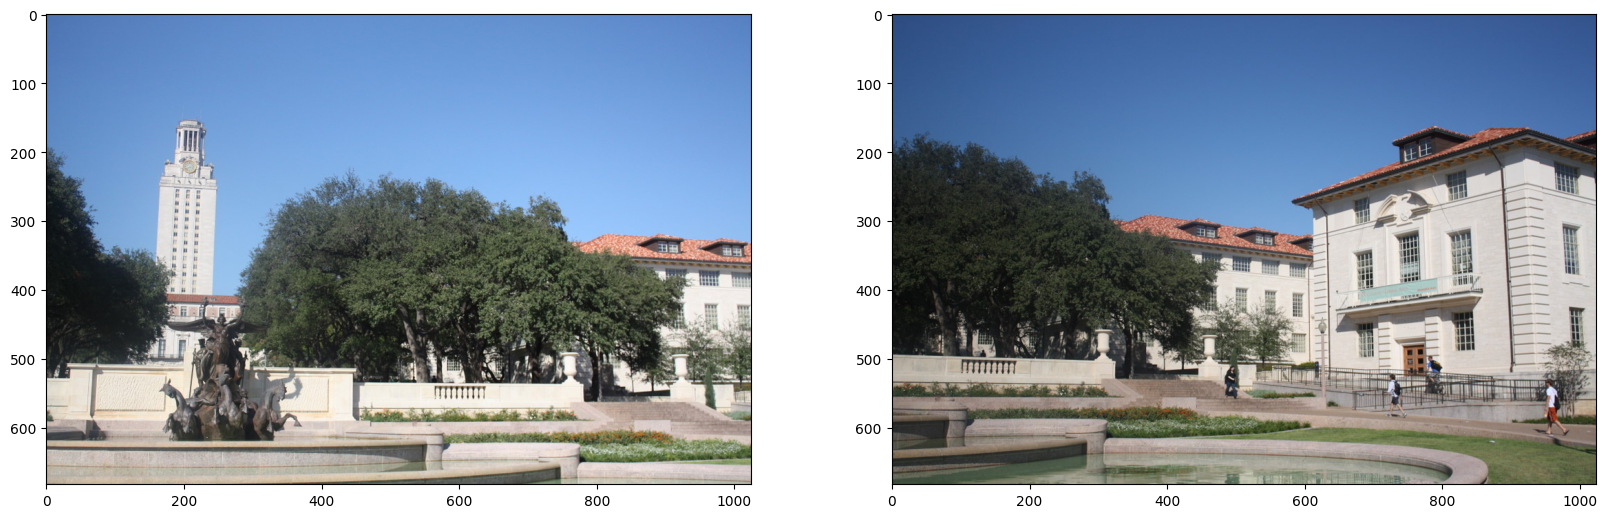

In [5]:
img1 = cv2.imread("data/pano_image1.jpg")
img2 = cv2.imread("data/pano_image2.jpg")
figure, axis = plt.subplots(1, 2, figsize=(20, 20))
axis[0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axis[1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

Number of matches: 4195
Number of good matches: 1072


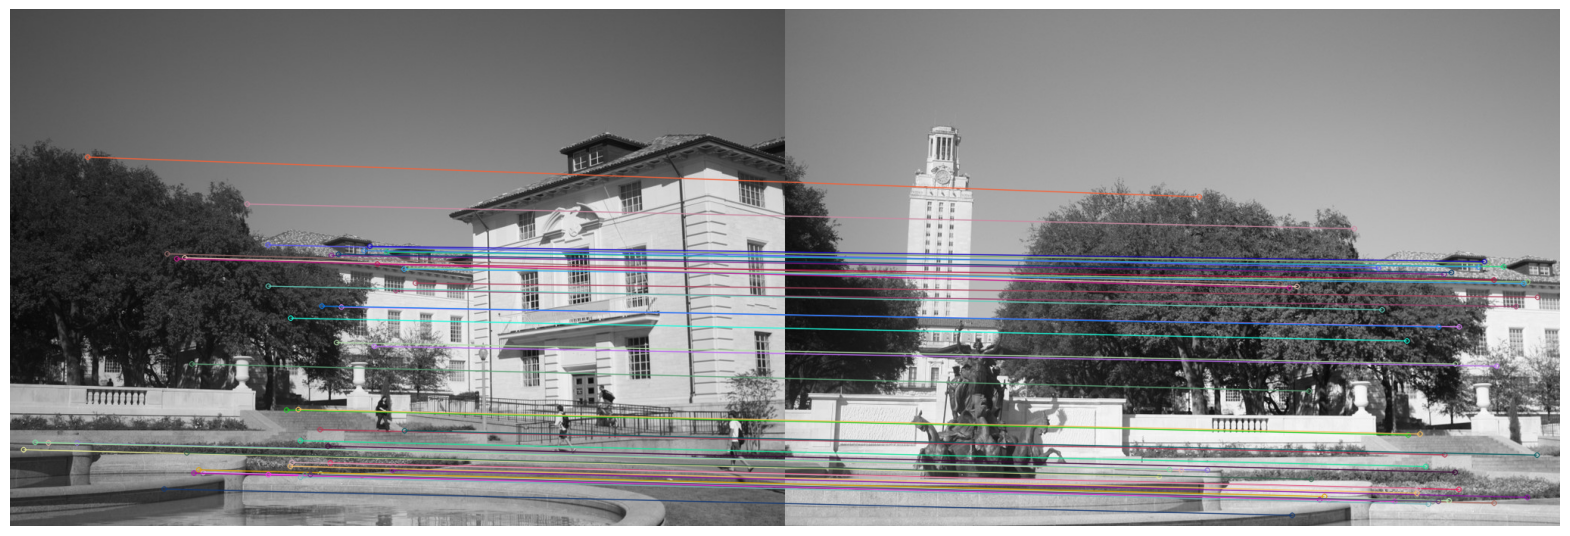

In [6]:
correspondences, matched_img = getMatches(img1, img2)
plt.imshow(matched_img, figure=plt.figure(figsize=(20, 20)))
plt.axis("off")
plt.show()

### **Computing the homography using Direct Linear Transform (DLT)**


In [7]:
def compute_H(correspondences):

    A = []
    for p, p_dash in correspondences:
        A.append(
            [-p[0], -p[1], -1, 0, 0, 0, p[0] * p_dash[0], p[1] * p_dash[0], p_dash[0]]
        )
        A.append(
            [0, 0, 0, -p[0], -p[1], -1, p[0] * p_dash[1], p[1] * p_dash[1], p_dash[1]]
        )

    A = np.array(A)
    U, D, V_transpose = svd(A)
    H = np.reshape(V_transpose[8], (3, 3))
    H /= H[2, 2]

    return H

### **Estimating homography using RANSAC**


In [8]:
def RANSAC(correspondences):
    max_inliers = []

    for _ in range(500):

        random_indices = random.sample(range(0, len(correspondences)), 4)
        random_correspondences = [correspondences[i] for i in random_indices]

        H = compute_H(random_correspondences)

        curr_inliers = []
        for corr in correspondences:
            P = corr[0]
            mapped_P = tuple(
                map(
                    int,
                    (
                        np.dot(H, np.transpose([P[0], P[1], 1]))
                        / (np.dot(H, np.transpose([P[0], P[1], 1]))[2])
                    ).astype(int)[:2],
                )
            )
            e = np.linalg.norm(np.asarray(corr[1]) - np.asarray(mapped_P))
            if e < 5:
                curr_inliers.append(corr)

        if len(curr_inliers) > len(max_inliers):
            max_inliers = curr_inliers

    return compute_H(max_inliers)

In [9]:
def interpolation(x, y, image):
    x1 = math.floor(x)
    x2 = math.ceil(x)
    y1 = math.floor(y)
    y2 = math.ceil(y)
    w1 = (abs(y - y2)) * (abs(x - x2)) * image[y1][x1]
    w2 = (abs(y - y1)) * (abs(x - x1)) * image[y2][x2]
    w3 = (abs(y - y1)) * (abs(x - x2)) * image[y1][x2]
    w4 = (abs(y - y2)) * (abs(x - x1)) * image[y2][x1]
    return w1 + w2 + w3 + w4

In [10]:
def get_borders(corner1, corner2, corner3, corner4):
    min_x = min(corner1[0], corner2[0], corner3[0], corner4[0])
    min_y = min(corner1[1], corner2[1], corner3[1], corner4[1])
    max_x = max(corner1[0], corner2[0], corner3[0], corner4[0])
    max_y = max(corner1[1], corner2[1], corner3[1], corner4[1])
    return (min_x, min_y), (max_x, max_y)

In [11]:
def compute_p_dash(h, p, check=False):
    p = np.transpose([p[0], p[1], 1])
    p_dash = np.dot(h, p)
    p_dash /= p_dash[2]
    if check == True:
        return (p_dash[0], p_dash[1])
    return (int(p_dash[0]), int(p_dash[1]))

In [12]:
def getCorners(img, h):
    img_shape = img.shape
    p1_dash = compute_p_dash(h, (0, 0))
    p2_dash = compute_p_dash(h, (0, img_shape[0]))
    p3_dash = compute_p_dash(h, (img_shape[1], img_shape[0]))
    p4_dash = compute_p_dash(h, (img_shape[1], 0))
    return p1_dash, p2_dash, p3_dash, p4_dash

In [16]:
def warp_image(img1, img2, h, corners=False):

    corner1_estimate, corner2_estimate, corner3_estimate, corner4_estimate = getCorners(
        img1, h
    )

    border_min_point, _ = get_borders(
        corner1_estimate, corner2_estimate, (0, 0), (0, img2.shape[0])
    )
    _, border_max_point = get_borders(
        corner3_estimate,
        corner4_estimate,
        (img2.shape[1], 0),
        (img2.shape[1], img2.shape[0]),
    )

    height = border_max_point[1] - border_min_point[1]
    width = border_max_point[0] - border_min_point[0]
    final_img = np.zeros((height, width, 3))

    warped_min_border, warped_max_border = get_borders(
        corner1_estimate, corner2_estimate, corner3_estimate, corner4_estimate
    )

    corners = [
        (0, 0),
        (0, img2.shape[0]),
        (img2.shape[1], img2.shape[0], (img2.shape[1], 0)),
    ]

    if border_min_point[0] == 0 and border_min_point[1] == 0:
        final_img[0 : img2.shape[0], 0 : img2.shape[1]] = img2
    else:
        shifted_corners = [
            (point[0] - warped_min_border[0], point[1] - warped_min_border[1])
            for point in corners
        ]
        final_img[
            shifted_corners[0][1] : shifted_corners[2][1],
            shifted_corners[0][0] : shifted_corners[2][0],
        ] = img2

    h_inverse = np.linalg.inv(h)
    for i in range(warped_min_border[0], warped_max_border[0]):
        for j in range(warped_min_border[1], warped_max_border[1]):
            p_dash = compute_p_dash(h_inverse, (i, j), True)
            if (
                p_dash[0] < 0
                or p_dash[0] > img1.shape[1] - 1
                or p_dash[1] < 0
                or p_dash[1] > img1.shape[0] - 1
            ):
                continue
            new_x = abs(border_min_point[0] - i)
            new_y = abs(border_min_point[1] - j)

            final_img[new_y][new_x] = interpolation(p_dash[0], p_dash[1], img1)

    return final_img, warped_min_border

Left Homography Matrix:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


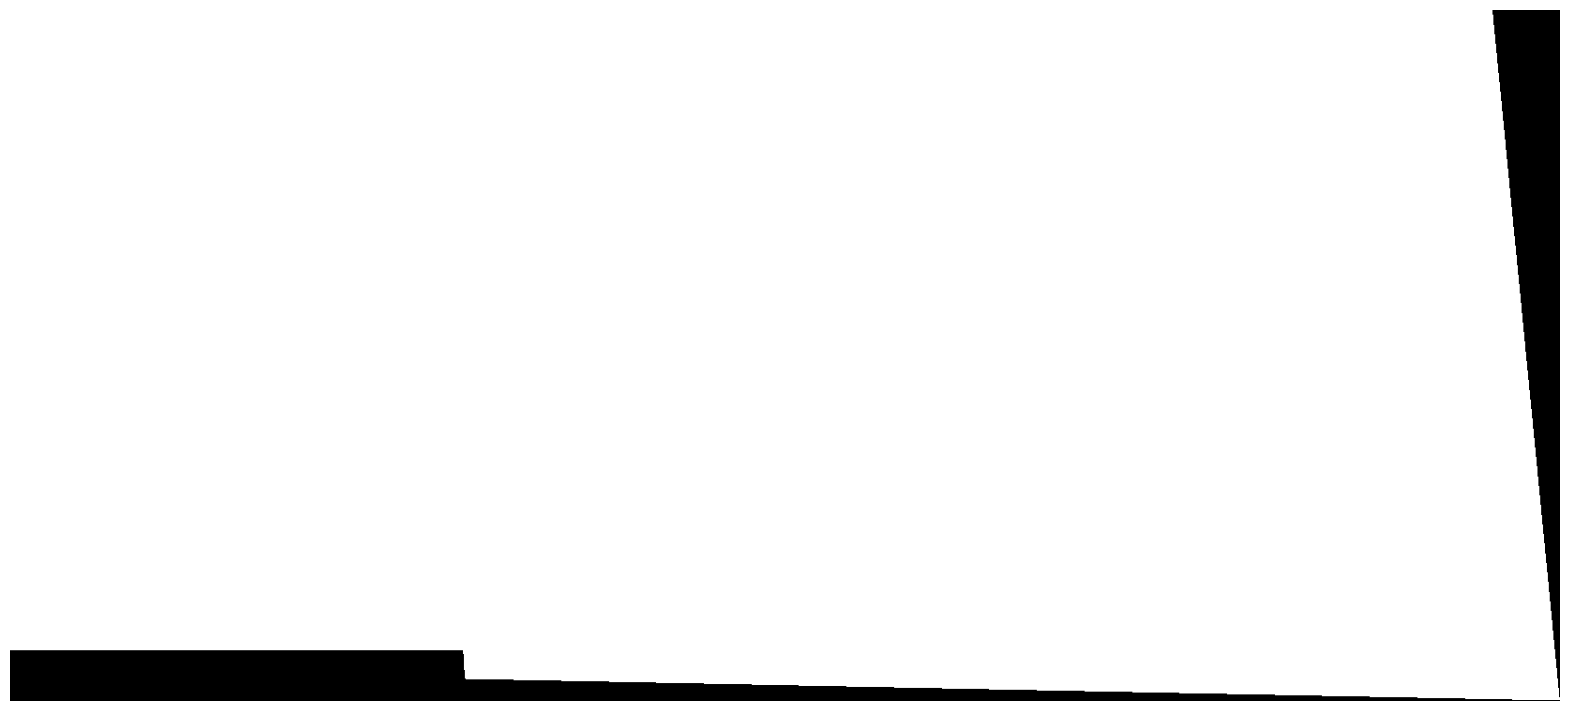

In [ ]:
h_left = RANSAC(correspondences)
print("Left Homography Matrix:")
warped_img_left, _ = warp_image(img1, img2, h_left, True)
plt.imshow(warped_img_left, figure=plt.figure(figsize=(20, 20)))
plt.axis("off")
plt.show()